
# DATS 2102 — Week 9: Color & Accessibility (Demos)

**Goal:** Practical demonstrations of choosing color scales that match data types and building accessible charts in Matplotlib, Seaborn, Altair, and Plotly.

**What you'll do**
- Pick sequential/diverging/categorical palettes appropriately
- Avoid rainbow/jet for ordered data
- Check contrast and add redundant encodings
- Try quick CVD simulations and grayscale checks



## Setup

Run this once to import libraries. Altair & Plotly are optional but recommended.


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Optional libs (comment out any you don't need)
import seaborn as sns
import plotly.express as px
import altair as alt
from vega_datasets import data as vega_data
import colorcet as cc



## Match palette to data type

- **Categorical** : distinct hues, similar lightness (limit to ~6–10 categories).
- **Sequential (ordered)** : monotonic lightness (e.g., `viridis`, `mako`, `Greys`).
- **Diverging (deviation around a center)** : light–dark–light with neutral midpoint (e.g., `coolwarm`, `RdBu`, `vlag`).



### Matplotlib: Sequential & Diverging colormaps


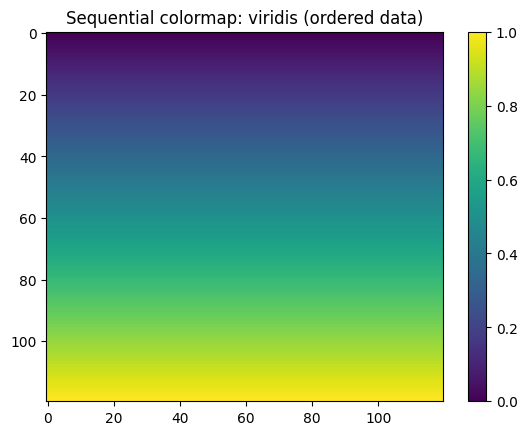

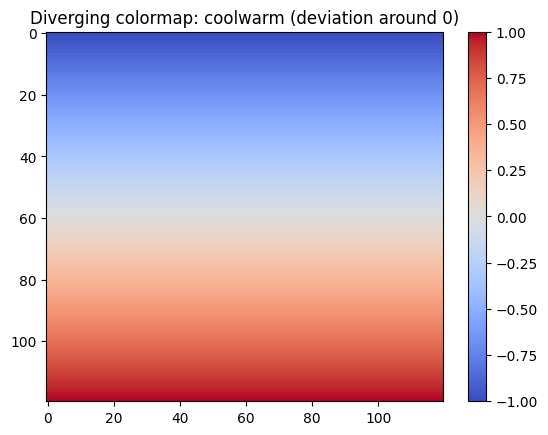

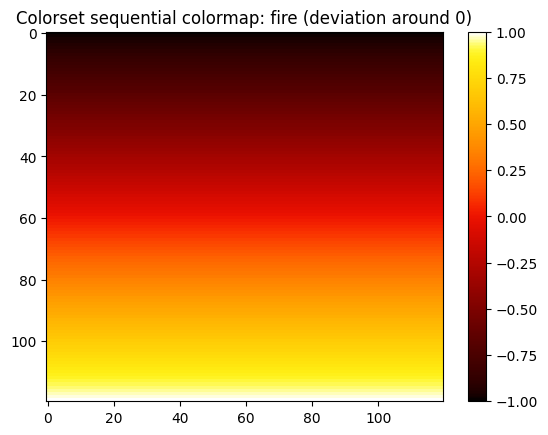

In [ ]:

import matplotlib.pyplot as plt
np.random.seed(0)

# Sequential example
data_seq = np.outer(np.linspace(0, 1, 120), np.ones(120))
plt.figure()
plt.imshow(data_seq, aspect='auto', cmap='viridis')
plt.title("Sequential colormap: viridis (ordered data)")
plt.colorbar()
plt.show()

# Diverging example (center at 0)
data_div = np.outer(np.linspace(-1, 1, 120), np.ones(120))
plt.figure()
plt.imshow(data_div, aspect='auto', cmap='coolwarm')
plt.title("Diverging colormap: coolwarm (deviation around 0)")
plt.colorbar()
plt.show()


# Diverging example (center at 0)
data_div = np.outer(np.linspace(-1, 1, 120), np.ones(120))
plt.figure()
plt.imshow(data_div, aspect='auto', cmap=cc.cm.fire)
plt.title("Colorset sequential colormap: fire")
plt.colorbar()
plt.show()


### Matplotlib: Categorical — prefer styles + color


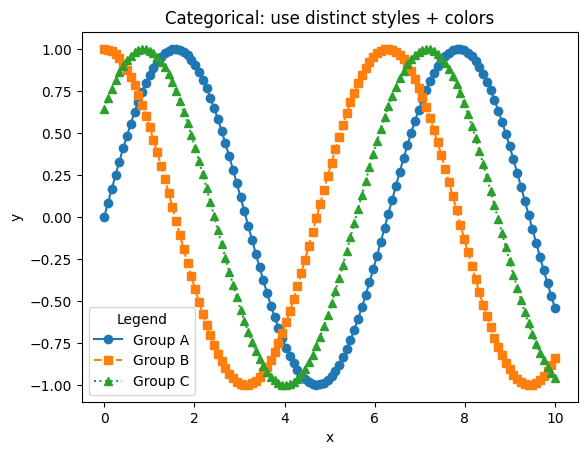

In [32]:

x = np.linspace(0, 10, 120)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.sin(x + 0.7)

plt.figure()
plt.plot(x, y1, label="Group A", linestyle='-', marker='o')
plt.plot(x, y2, label="Group B", linestyle='--', marker='s')
plt.plot(x, y3, label="Group C", linestyle=':', marker='^')
plt.legend(title="Legend")
plt.title("Categorical: use distinct styles + colors")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



## Seaborn: categorical, sequential heatmap, diverging heatmap


In [33]:

import seaborn as sns
import matplotlib.pyplot as plt

tips = sns.load_dataset("tips")
plt.figure()
sns.countplot(data=tips, x="day", hue="sex", palette="Set2")
plt.title("Categorical (limited categories) — ColorBrewer-style palette")
plt.show()

flights = sns.load_dataset("flights").pivot(index="month", columns="year", values="passengers")
plt.figure()
sns.heatmap(flights, cmap="mako")   # sequential
plt.title("Sequential palette on heatmap (mako)")
plt.show()

plt.figure()
sns.heatmap(flights - flights.mean().mean(), center=0, cmap="vlag")  # diverging around 0
plt.title("Diverging palette centered at 0 (vlag)")
plt.show()



## Altair: categorical vs sequential vs diverging

> If running in Jupyter, run `alt.renderers.enable('default')`. In some environments you may need `'mimetype'`.


In [34]:

import altair as alt
from vega_datasets import data

cars = data.cars()

# Categorical
chart1 = alt.Chart(cars).mark_point().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color=alt.Color('Origin:N', legend=alt.Legend(title='Origin'))
).properties(title='Categorical colors')

# Sequential
chart2 = alt.Chart(cars).mark_point().encode(
    x='Weight_in_lbs',
    y='Miles_per_Gallon',
    color=alt.Color('Horsepower:Q', scale=alt.Scale(scheme='viridis'))
).properties(title='Sequential (viridis)' )

# Diverging (deviation from mean MPG)
mean_mpg = cars['Miles_per_Gallon'].mean()
chart3 = alt.Chart(cars).mark_point().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color=alt.Color('Miles_per_Gallon:Q',
                    scale=alt.Scale(scheme='redblue', domain=[0, mean_mpg, 50]))
).properties(title='Diverging (redblue, centered)')

(chart1 | chart2 | chart3)


alt.HConcatChart(...)


## Plotly Express: categorical, sequential, diverging


In [35]:

import plotly.express as px

gap = px.data.gapminder()

fig1 = px.scatter(gap.query("year==2007"), x="gdpPercap", y="lifeExp",
                  color="continent", hover_name="country",
                  title="Categorical: continents")
fig1.show()

fig2 = px.scatter(gap.query("year==2007"), x="gdpPercap", y="lifeExp",
                  color="pop", hover_name="country",
                  color_continuous_scale="Viridis",
                  title="Sequential: population")
fig2.show()

df = gap.query("year==2007").copy()
df["dev_lifeExp"] = df["lifeExp"] - df["lifeExp"].mean()
fig3 = px.scatter(df, x="gdpPercap", y="lifeExp",
                  color="dev_lifeExp",
                  color_continuous_scale=px.colors.diverging.RdBu,
                  color_continuous_midpoint=0,
                  title="Diverging: deviation from mean lifeExp")
fig3.show()



## Accessibility helpers: WCAG contrast ratio

Quick utilities to compute contrast ratios and check thresholds (4.5:1 normal text; 3:1 large text).


In [36]:

def srgb_to_linear(c):
    c = c / 255.0
    return c/12.92 if c <= 0.04045*255 else ((c/255.0 + 0.055)/1.055)**2.4  # careful with scaling

def rel_luminance(rgb):
    # rgb: tuple of ints 0-255
    R, G, B = [v/255.0 for v in rgb]
    def f(u): return u/12.92 if u <= 0.04045 else ((u+0.055)/1.055)**2.4
    r_lin, g_lin, b_lin = f(R), f(G), f(B)
    return 0.2126*r_lin + 0.7152*g_lin + 0.0722*b_lin

def contrast_ratio(fg_rgb, bg_rgb):
    L1 = rel_luminance(fg_rgb)
    L2 = rel_luminance(bg_rgb)
    L_light, L_dark = max(L1, L2), min(L1, L2)
    return (L_light + 0.05) / (L_dark + 0.05)

def passes_wcag(fg_rgb, bg_rgb, large=False):
    cr = contrast_ratio(fg_rgb, bg_rgb)
    threshold = 3.0 if large else 4.5
    return cr, cr >= threshold

# Examples
fg = (33, 33, 33)     # dark gray
bg = (255, 255, 255)  # white
cr, ok = passes_wcag(fg, bg, large=False)
print("Contrast ratio:", round(cr, 2), "| Pass normal text?", ok)

fg = (150, 150, 150)
bg = (255, 255, 255)
cr, ok = passes_wcag(fg, bg, large=False)
print("Contrast ratio:", round(cr, 2), "| Pass normal text?", ok)


Contrast ratio: 16.1 | Pass normal text? True
Contrast ratio: 2.96 | Pass normal text? False



## Grayscale and quick CVD simulation

These are rough, educational transforms (not a medical simulator).


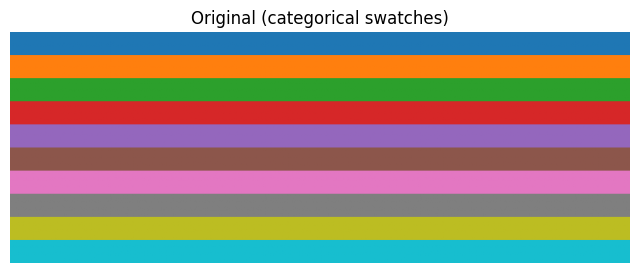

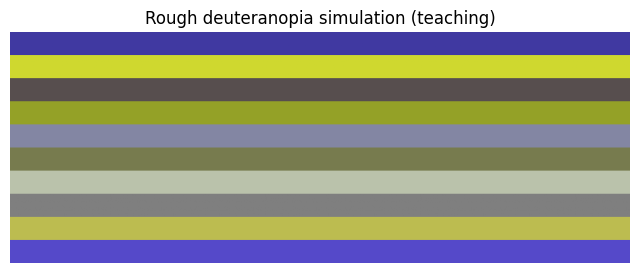

In [37]:

import numpy as np
import matplotlib.pyplot as plt

def to_grayscale(rgb_image):
    # rgb_image: (H,W,3) floats 0..1
    r, g, b = rgb_image[...,0], rgb_image[...,1], rgb_image[...,2]
    gray = 0.2126*r + 0.7152*g + 0.0722*b
    return np.dstack([gray, gray, gray])

# Simple linear transform approximations for protanopia/deuteranopia
# (Brettel/Vienot inspired, crude for teaching purposes)
def simulate_deuteranopia(rgb):
    M = np.array([[0.625, 0.375, 0.000],
                  [0.700, 0.300, 0.000],
                  [0.000, 0.300, 0.700]])
    shp = rgb.shape
    flat = rgb.reshape(-1,3)
    sim = flat @ M.T
    sim = np.clip(sim, 0, 1)
    return sim.reshape(shp)

# Demo: color bar
x = np.linspace(0,1,256)
bar = np.tile(x, (30,1))
rgb = plt.cm.tab10(np.linspace(0,1,10))[:,:3]
img = np.vstack([np.tile(c,(20,256,1)) for c in rgb])

plt.figure(figsize=(8,3))
plt.imshow(img, aspect='auto')
plt.title("Original (categorical swatches)")
plt.axis('off')
plt.show()

plt.figure(figsize=(8,3))
plt.imshow(to_grayscale(img), aspect='auto')
plt.title("Grayscale check (lightness ordering)")
plt.axis('off')
plt.show()

plt.figure(figsize=(8,3))
plt.imshow(simulate_deuteranopia(img), aspect='auto')
plt.title("Rough deuteranopia simulation (teaching)")
plt.axis('off')
plt.show()



## Redundant encodings: shape/linestyle + color


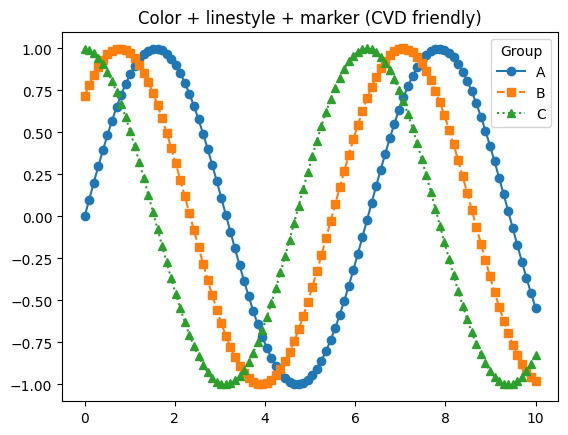

In [38]:

x = np.linspace(0, 10, 100)
plt.figure()
plt.plot(x, np.sin(x), label="A", linestyle='-', marker='o')
plt.plot(x, np.sin(x+0.8), label="B", linestyle='--', marker='s')
plt.plot(x, np.sin(x+1.6), label="C", linestyle=':', marker='^')
plt.legend(title="Group")
plt.title("Color + linestyle + marker (CVD friendly)")
plt.show()


In [39]:
import matplotlib.colors as mcolors
import numpy as np

# Convert to grayscale to check luminance contrast
img = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(img, cmap="viridis", aspect="auto")
plt.title("Luminance contrast check (Viridis)")
plt.axis('off')
plt.show()


## In-class activity

1. Take a chart that uses rainbow/low-contrast colors.
2. Refactor it with an appropriate palette and redundant encodings.
3. Add a brief note: *why is the new design better?*


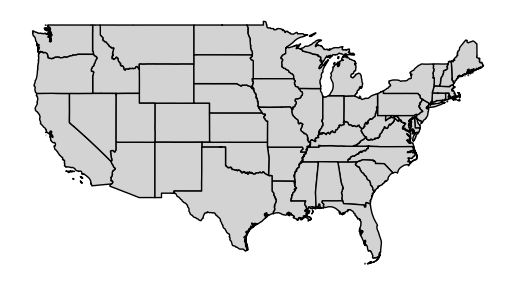

In [43]:
import geopandas as gpd
# shapefile_path = "data/map_20m.geojson"
shapefile_path = "data/map_us_only.geojson"

gdf = gpd.read_file(shapefile_path)
ax = gdf.plot(color='lightgray', edgecolor='black')
gdf.crs
ax.set_axis_off()

In [44]:
import pandas as pd
polys = gdf.copy()            # has State ID
# print(polys.head())
attrs = pd.read_csv("data/unemployment.csv")                     # State ID, count, population
# print(attrs.head())
g = pd.merge(polys, attrs, left_on='GEO_ID', right_on='Geo_GEO_ID', how='left')
print(g.head())

        GEO_ID STATE         NAME LSAD  CENSUSAREA                                           geometry  Geo__geoid_    Geo_qname Geo_STUSAB  Geo_SUMLEV  ...  SE_A14001_008  SE_A14001_009  SE_A14001_010  SE_A14001_011  SE_A14001_012  SE_A14001_013  \
0  0400000US04    04      Arizona       113594.084  POLYGON ((-112.53859 37.00067, -112.53454 37.0...            4      Arizona         AZ          40  ...          97415         104712         104022         204470         271522         379387   
1  0400000US05    05     Arkansas        52035.477  POLYGON ((-94.04296 33.01922, -94.04304 33.079...            5     Arkansas         AR          40  ...          57686          50093          50334          91063         116538         150186   
2  0400000US06    06   California       155779.220  MULTIPOLYGON (((-120.24848 33.99933, -120.2473...            6   California         CA          40  ...         376450         378929         373874         723626        1058686        1583411   
3  0

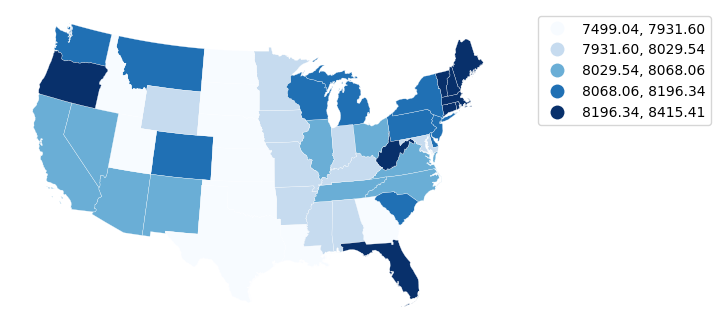

In [46]:
g = g.to_crs("ESRI:102003")                          # equal-area for area-based ops
g["rate_per_10k"] = (g["SE_A17002_001"] / g["SE_A00001_001"]) * 10000
ax = g.plot(column="rate_per_10k", cmap="Blues", scheme="Quantiles", k=5, legend=True, legend_kwds= dict(loc='upper left', bbox_to_anchor=(1.05, 1)), edgecolor="white", linewidth=0.2)
ax.set_axis_off()

/opt/anaconda3/envs/dataviz/lib/python3.12/site-packages/geopandas/plotting.py:746: UserWarning:

Numba not installed. Using slow pure python version.



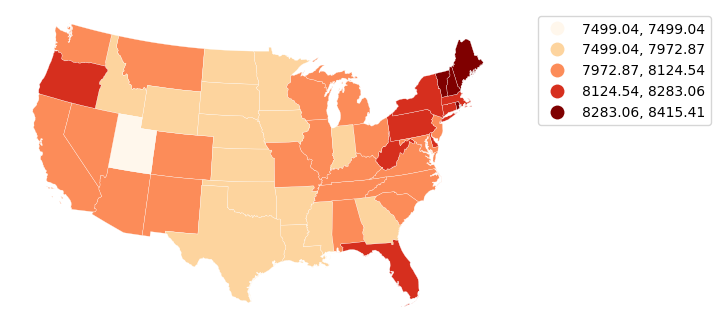

In [47]:
ax = g.plot(column="rate_per_10k", cmap="OrRd", scheme="fisherjenks", k=5, legend=True, legend_kwds= dict(loc='upper left', bbox_to_anchor=(1.05, 1)), edgecolor="white", linewidth=0.2)
ax.set_axis_off()

/opt/anaconda3/envs/dataviz/lib/python3.12/site-packages/geopandas/plotting.py:746: UserWarning:

Numba not installed. Using slow pure python version.



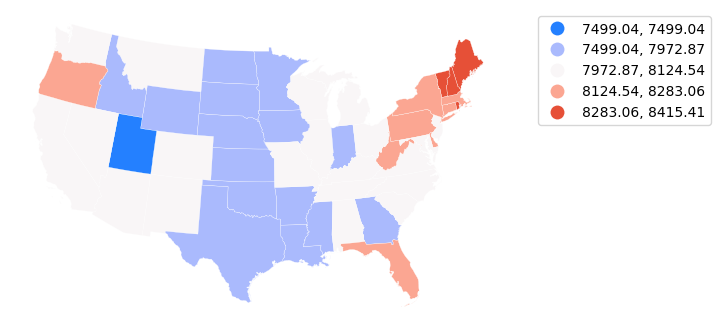

In [48]:
ax = g.plot(column="rate_per_10k", cmap=cc.cm.CET_D9, scheme="fisherjenks", k=5, legend=True, legend_kwds= dict(loc='upper left', bbox_to_anchor=(1.05, 1)), edgecolor="white", linewidth=0.2)
ax.set_axis_off()

/opt/anaconda3/envs/dataviz/lib/python3.12/site-packages/geopandas/plotting.py:746: UserWarning:

Numba not installed. Using slow pure python version.



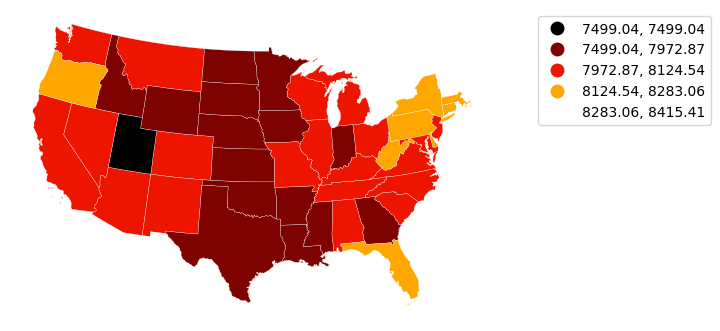

In [49]:
ax = g.plot(column="rate_per_10k", cmap=cc.cm.fire, scheme="fisherjenks", k=5, legend=True, legend_kwds= dict(loc='upper left', bbox_to_anchor=(1.05, 1)), edgecolor="white", linewidth=0.2)
ax.set_axis_off()